# XAI Assignment 2


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MrinalGoel643/XAI/blob/main/regression-interpretability.ipynb)

In this notebook, we perform an EDA to understand the telco customer dataset available at - https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data. We test for a few assumptions mentioned in class for specific model types and then finally compare the model predictions.

In [15]:
# imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
!pip install pygam

In [17]:
# load the dataset and check datatypes

path_to_dataset_csv = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv" # change as required

df = pd.read_csv(path_to_dataset_csv)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [18]:
# Checking for missing values

null_df = pd.DataFrame((df.isnull().sum())*100/df.shape[0],index=df.columns,columns=['Missing %'])
null_df[null_df['Missing %']>0]

,Missing %


In [19]:
# Checking for duplicate rows

df[df.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [20]:
# Extract the numeric variables

numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns
print(numeric_vars)

# remove SeniorCitizen and add TotalCharges
df["SeniorCitizen"] = df["SeniorCitizen"].astype(str)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0) # fill 0 for new customers with 0 tenure

numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns
print(numeric_vars)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')
Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


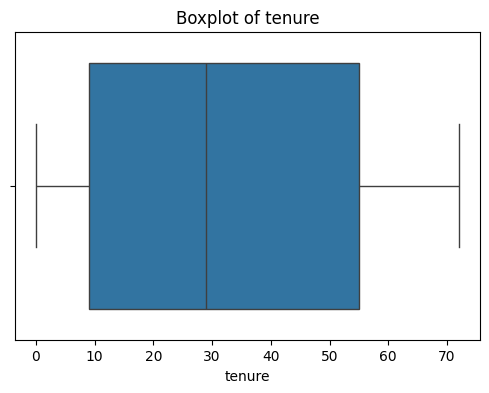

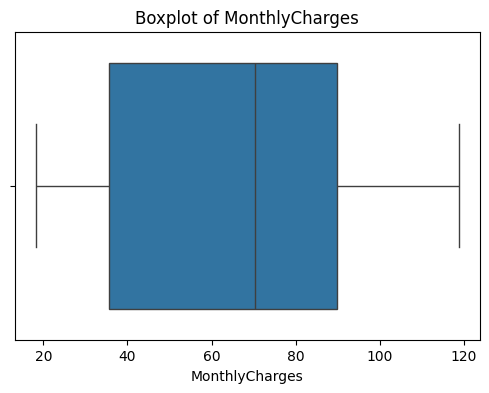

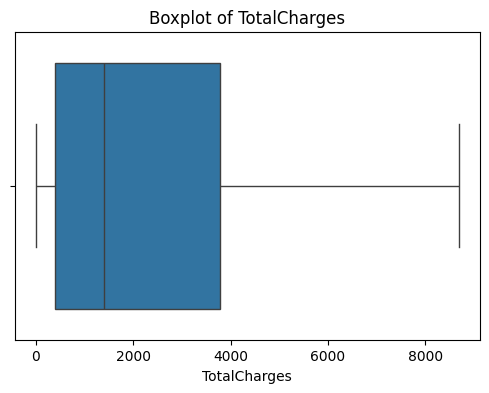

In [21]:
# Plot boxplots to check datapoint distribution and find outliers

for col in numeric_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

Till now, we have checked for missing values and duplicate rows. Post that, we extracted the numeric columns and did an outlier detection using boxplots. In the boxplots, tenure and MonthlyCharges seem fine but the TotalCharges streches a lot, but there are no visible outliers.

In [22]:
# convert target to a continuous variable for regression

df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1}).astype(int)

# Assumptions tests

# Assumptions for Linearity


In Linear Regression:
It is assumed that the relationship between predictors (X) and the target (Y) is linear.

In Logistic Regression:
The assumption is not that X and Y themselves are linearly related, but that the predictors (X) have a linear relationship with the logit of the outcome.

In GAMs:
Linearity is not required.

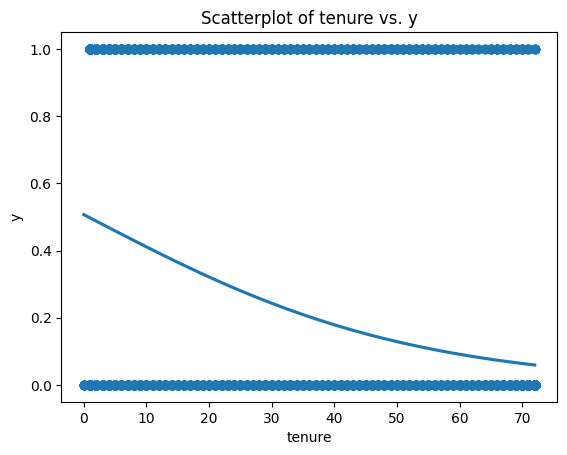

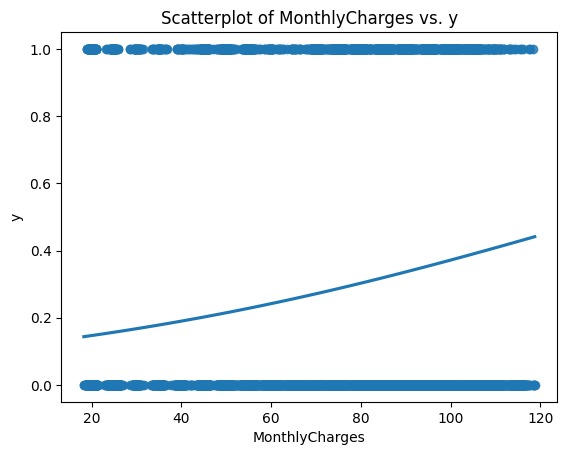

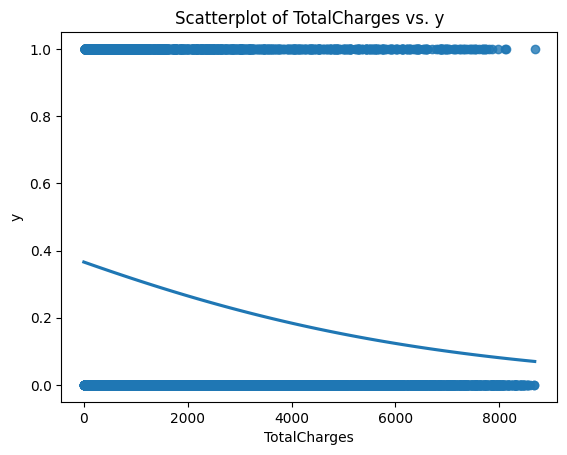

In [23]:
#  Linearity - Scatter plot

for col in numeric_vars:
    sns.regplot(x=col, y="Churn", data=df, logistic=True, ci=None)
    plt.xlabel(col)
    plt.ylabel("y")
    plt.title(f"Scatterplot of {col} vs. y")
    plt.show()



Here we are trying to test the linearity between the predictor variables and the target variable (churn). A basic scatterplot did not give us much insight as the target variable is not truly a continuous variable (Hence the points are stacked at 0 and 1). But from the logit plots it is clear that the linearity in logit assumption holds true because the logit curves are smooth. For example, in the Churn vs TotalCharges plot higher TotalCharges are associated with lower churn probability.

# Independence of Observations

When we are trying to model a relationship between predictor and target, it can be quite confusing if the observations are not independent. In our case, we can confirm if the observations are independent based on a single observation per customer ID.

In [24]:
# Independence of observations

n_total = df.shape[0]
n_unique = df["customerID"].nunique()

print(n_total, n_unique)

7043 7043


# Multicollinearity

If variables are closely related it is difficult to model their individual effect. This assumption is important for all 3 of our models.

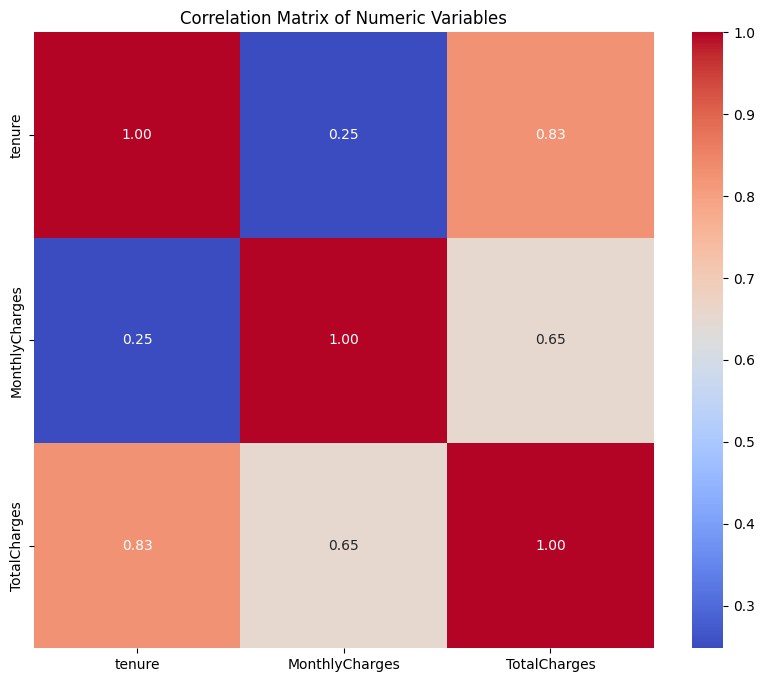

In [25]:

corr_matrix = df[numeric_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

Based on the correlation heatmap, looks like TotalCharges and tenure have a high correlation. This is probably because TotalCharges is tenure x MonthlyCharges. Let's also do a VIF test.

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = df[numeric_vars]

# Add constant for intercept
X_const = sm.add_constant(X)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

print(vif_data)


# The above code snippet was generated using ChatGPT5 on 09/13/25 at 6:37pm.

          feature        VIF
0           const  14.899868
1          tenure   5.836728
2  MonthlyCharges   3.216730
3    TotalCharges   9.510931


Since the TotalCharges is nothing but MonthlyCharges X Tenure, there is a high VIF value of TotalCharges. Since both our MultiCollinearity tests indicated that TotalCharges has high multicollinearity, let us drop it before building our models. Also we will drop customer_ID because there is no way that could give us any information about churn. We will also perform feature encoding for our catagorical columns and feature scaling before training the model.

In [27]:

# Drop ID column
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])


yes_no_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]

service_cols = ["MultipleLines", "OnlineSecurity", "OnlineBackup",
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

# Simple Yes/No
for col in yes_no_cols:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0})

# Service-related (Yes/No/No service)
for col in service_cols:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0, "No phone service": 0, "No internet service": 0})

if "gender" in df.columns:
    df["gender"] = df["gender"].map({"Male": 1, "Female": 0})

# SeniorCitizen already 0/1 → no mapping needed

print(df.columns)

multi_cat_cols = ["Contract", "InternetService", "PaymentMethod"]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)


# The above code snippet was generated using ChatGPT5 on 09/13/25 at 8pm.


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


Now we will finally train our models - Linear regression, Logistic Regression and a GAM. Before that, we will drop TotalCharges and we will also scale our features.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
)
from pygam import LogisticGAM

# --- Config ---
test_size = 0.2
random_state = 42

# --- Data split ---
X = df.drop(columns=["Churn", "TotalCharges"])   # drop collinear TotalCharges
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

# --- Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

# --- 1. Linear Regression (OLS on churn) ---
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
lin_preds = lin_model.predict(X_test_scaled)
lin_class = (lin_preds >= 0.5).astype(int)  # convert to classification

'''
Fits OLS treating churn (0/1) as continuous.

Gets continuous predictions (probabilities but unbounded).

Converts to classification by thresholding at 0.5.
'''

results["Linear Regression"] = {
    "R²": r2_score(y_test, lin_preds),
    "MSE": mean_squared_error(y_test, lin_preds),
    "RMSE": np.sqrt(mean_squared_error(y_test, lin_preds)),
    "Accuracy": accuracy_score(y_test, lin_class),
    "AUC": roc_auc_score(y_test, lin_preds),
    "Report": classification_report(y_test, lin_class, output_dict=True)
}

# --- 2. Logistic Regression ---
log_model = LogisticRegression(max_iter=5000, solver="lbfgs", class_weight="balanced")
log_model.fit(X_train_scaled, y_train)
log_probs = log_model.predict_proba(X_test_scaled)[:, 1]
log_class = (log_probs >= 0.5).astype(int)

'''
Fits a logistic regression model, the correct baseline for churn.

class_weight="balanced" handles churn imbalance by giving higher weight to the minority class.

Produces probabilities (predict_proba) and class predictions (threshold = 0.5).
'''

results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, log_class),
    "AUC": roc_auc_score(y_test, log_probs),
    "Report": classification_report(y_test, log_class, output_dict=True)
}

# --- 3. GAM (Logistic) ---
gam = LogisticGAM().gridsearch(X_train_scaled, y_train)
gam_probs = gam.predict_proba(X_test_scaled)
gam_class = (gam_probs >= 0.5).astype(int)


'''

Fits a Logistic GAM with smooth splines for predictors.

.gridsearch() automatically tunes smoothness (penalties).

Outputs probabilities and class predictions.
'''

results["GAM"] = {
    "Accuracy": accuracy_score(y_test, gam_class),
    "AUC": roc_auc_score(y_test, gam_probs),
    "Report": classification_report(y_test, gam_class, output_dict=True)
}

# --- Print results ---
for model, metrics in results.items():
    print(f"\n=== {model} ===")
    if model == "Linear Regression":
        print(f"R²: {metrics['R²']:.4f}, MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}, AUC: {metrics['AUC']:.4f}")



# The above code snippet was generated with help from ChatGPT5 on 09/14/25 at 10:11am.
# This cell takes slightly longer to run arounfd 1-1.5 mins.

100% (11 of 11) |########################| Elapsed Time: 0:01:49 Time:  0:01:49



=== Linear Regression ===
R²: 0.2605, MSE: 0.1442, RMSE: 0.3797
Accuracy: 0.7991, AUC: 0.8337

=== Logistic Regression ===
Accuracy: 0.7402, AUC: 0.8382

=== GAM ===
Accuracy: 0.8027, AUC: 0.8465


# Interpreting the model results

Linear regression : Even though the values dont seem too bad, the linear regression model is not ideal for a problem in which you are predicting a continuous variable. Unlike the binary classification problem we are solving here. Even the warnings clearly prove this is a misfit.

Logistic regression : Definitely a better option for a classification problem.

GAM : Performs the best and indicates that there exists a predictor that has a non-linear relationship with the target which were not captured before.


# Post model training test for linearity
Now we will plot the Residuals vs predicted graph and also do the RESET test

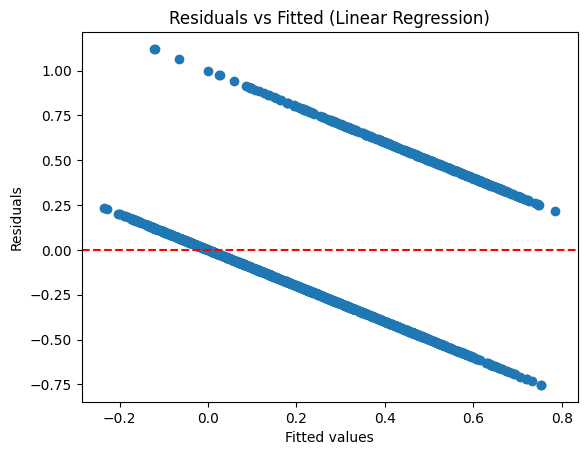

Reset test value :<F test: F=232.12551239652936, p=2.1652664594066522e-51, df_denom=5.61e+03, df_num=1>


In [29]:
from statsmodels.stats.diagnostic import linear_reset

# Residual plot (linear regression)
residuals = y_test - lin_model.predict(X_test_scaled)
plt.scatter(lin_model.predict(X_test_scaled), residuals)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Linear Regression)")
plt.show()

# RESET test (linear regression only)
X_const = sm.add_constant(X_train_scaled)
ols = sm.OLS(y_train, X_const).fit()
stat_value = sm.stats.linear_reset(ols, power=2, use_f=True)
print(f"Reset test value :{stat_value}")


# The above code snippet was generated using ChatGPT5 on 09/13/25 at 5:32pm.

# Interpreting the Residuals vs Fitted values plot

For Linear Regression, the Residuals vs Fitted plot shows two bands because of the binary outcome. This violates the assumptions of linearity and homoscedasticity. The overall F-test (F=232.13, p<0.001) indicates that predictors collectively explain variance in churn, but this result is not reliable due to assumption violations.

In [30]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print("Durbin-Watson:", dw)

Durbin-Watson: 1.9595444668418283


# Durbin Watson Interpretation

This test checks for autocorrelation and verifies correlation of residuals with their immediate lag. For Lienar regression, this test is satisfied as the value is closer to 2.

In [31]:

from statsmodels.stats.diagnostic import het_breuschpagan

# Refit an OLS model on training data (scaled)
X_const = sm.add_constant(X_train_scaled)
ols = sm.OLS(y_train, X_const).fit()

# Residuals and exog from the same fitted model
residuals = ols.resid
bp_test = het_breuschpagan(residuals, X_const)

labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
print(dict(zip(labels, bp_test)))


# The above code snippet was generated using ChatGPT5 on 09/14/25 at 10:45am.


{'LM stat': np.float64(1130.9448442188896), 'LM p-value': np.float64(2.457726622569143e-225), 'F stat': np.float64(64.05480987487728), 'F p-value': np.float64(9.104782896616789e-253)}


# Heteroscedasticity for Breusch–Pagan test

The Breusch–Pagan test for heteroscedasticity on the OLS model gave LM=1134.48 (p < 0.001) and F=70.76 (p < 0.001). Since both p-values are extremely small, we reject the null hypothesis of homoscedasticity. This indicates that the residual variance is not constant, violating the OLS assumption of homoscedasticity. Inference from the linear regression model is therefore unreliable. Logistic regression and GAMs do not require this assumption, so the violation is not relevant for those models.

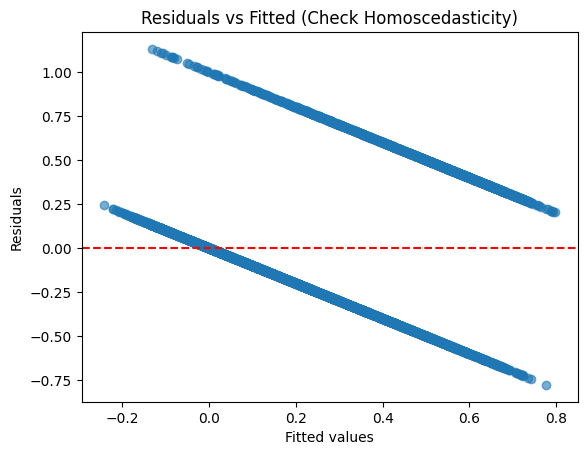

In [32]:
import statsmodels.api as sm


X_const = sm.add_constant(X_train_scaled)
ols = sm.OLS(y_train, X_const).fit()

# Extract fitted values and residuals
fitted_vals = ols.fittedvalues
residuals = ols.resid

# Plot residuals vs fitted
plt.scatter(fitted_vals, residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Check Homoscedasticity)")
plt.show()


# Normality Of Residuals

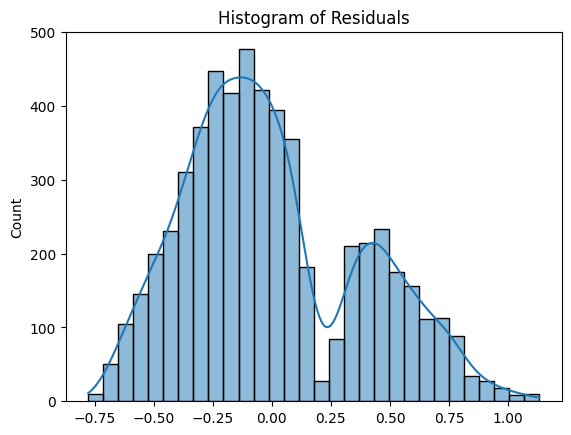

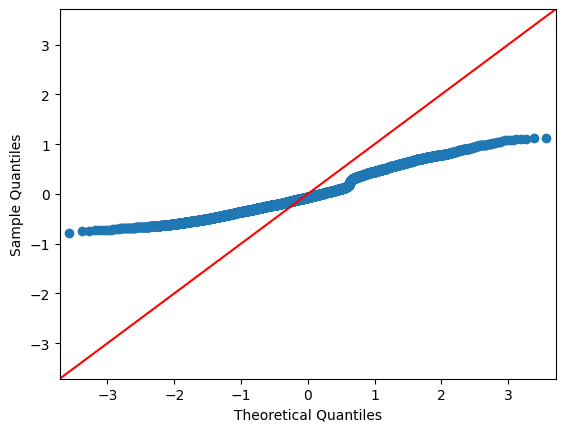

In [33]:
import scipy.stats as stats

# Histogram
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
sm.qqplot(residuals, line="45")
plt.show()


The bell curve is not symmetric and is not centered along 0. It also seems skewed based on the right tail. Similarly, in the Q-Q plot the points systematically move away from the 45 degree line. Both these tests are violated and hence the normality od residuals rule is violated.

# No Influential Outliers

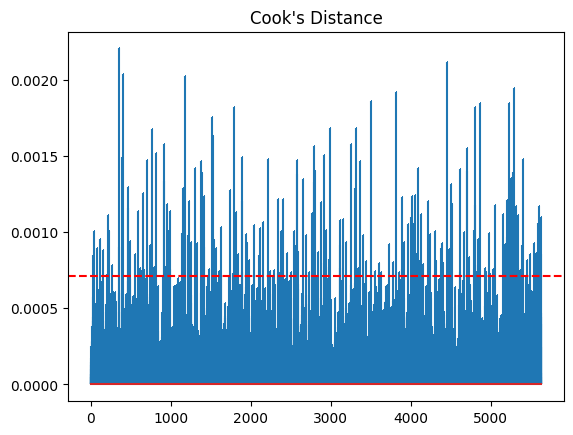

In [34]:
influence = ols.get_influence()
cooks = influence.cooks_distance[0]

plt.stem(range(len(cooks)), cooks, markerfmt=",")
plt.axhline(4/len(cooks), color="red", linestyle="--")
plt.title("Cook's Distance")
plt.show()


The Cook’s Distance plot shows that most observations fall below the influence threshold (4/n ≈ 0.0007). A small number of points exceed this cutoff slightly (up to ~0.0016), but none are extreme. This indicates that no single observation has undue influence on the regression model. Therefore, the assumption of no influential outliers is reasonably satisfied.

In [35]:
student_resid = influence.resid_studentized_external
outliers = (abs(student_resid) > 3)
print("Potential outliers:", outliers.sum())

# This cell takes slightly longer to run arounfd 1-1.5 mins.

Potential outliers: 2


There are only 2 potential outliers which is alright.

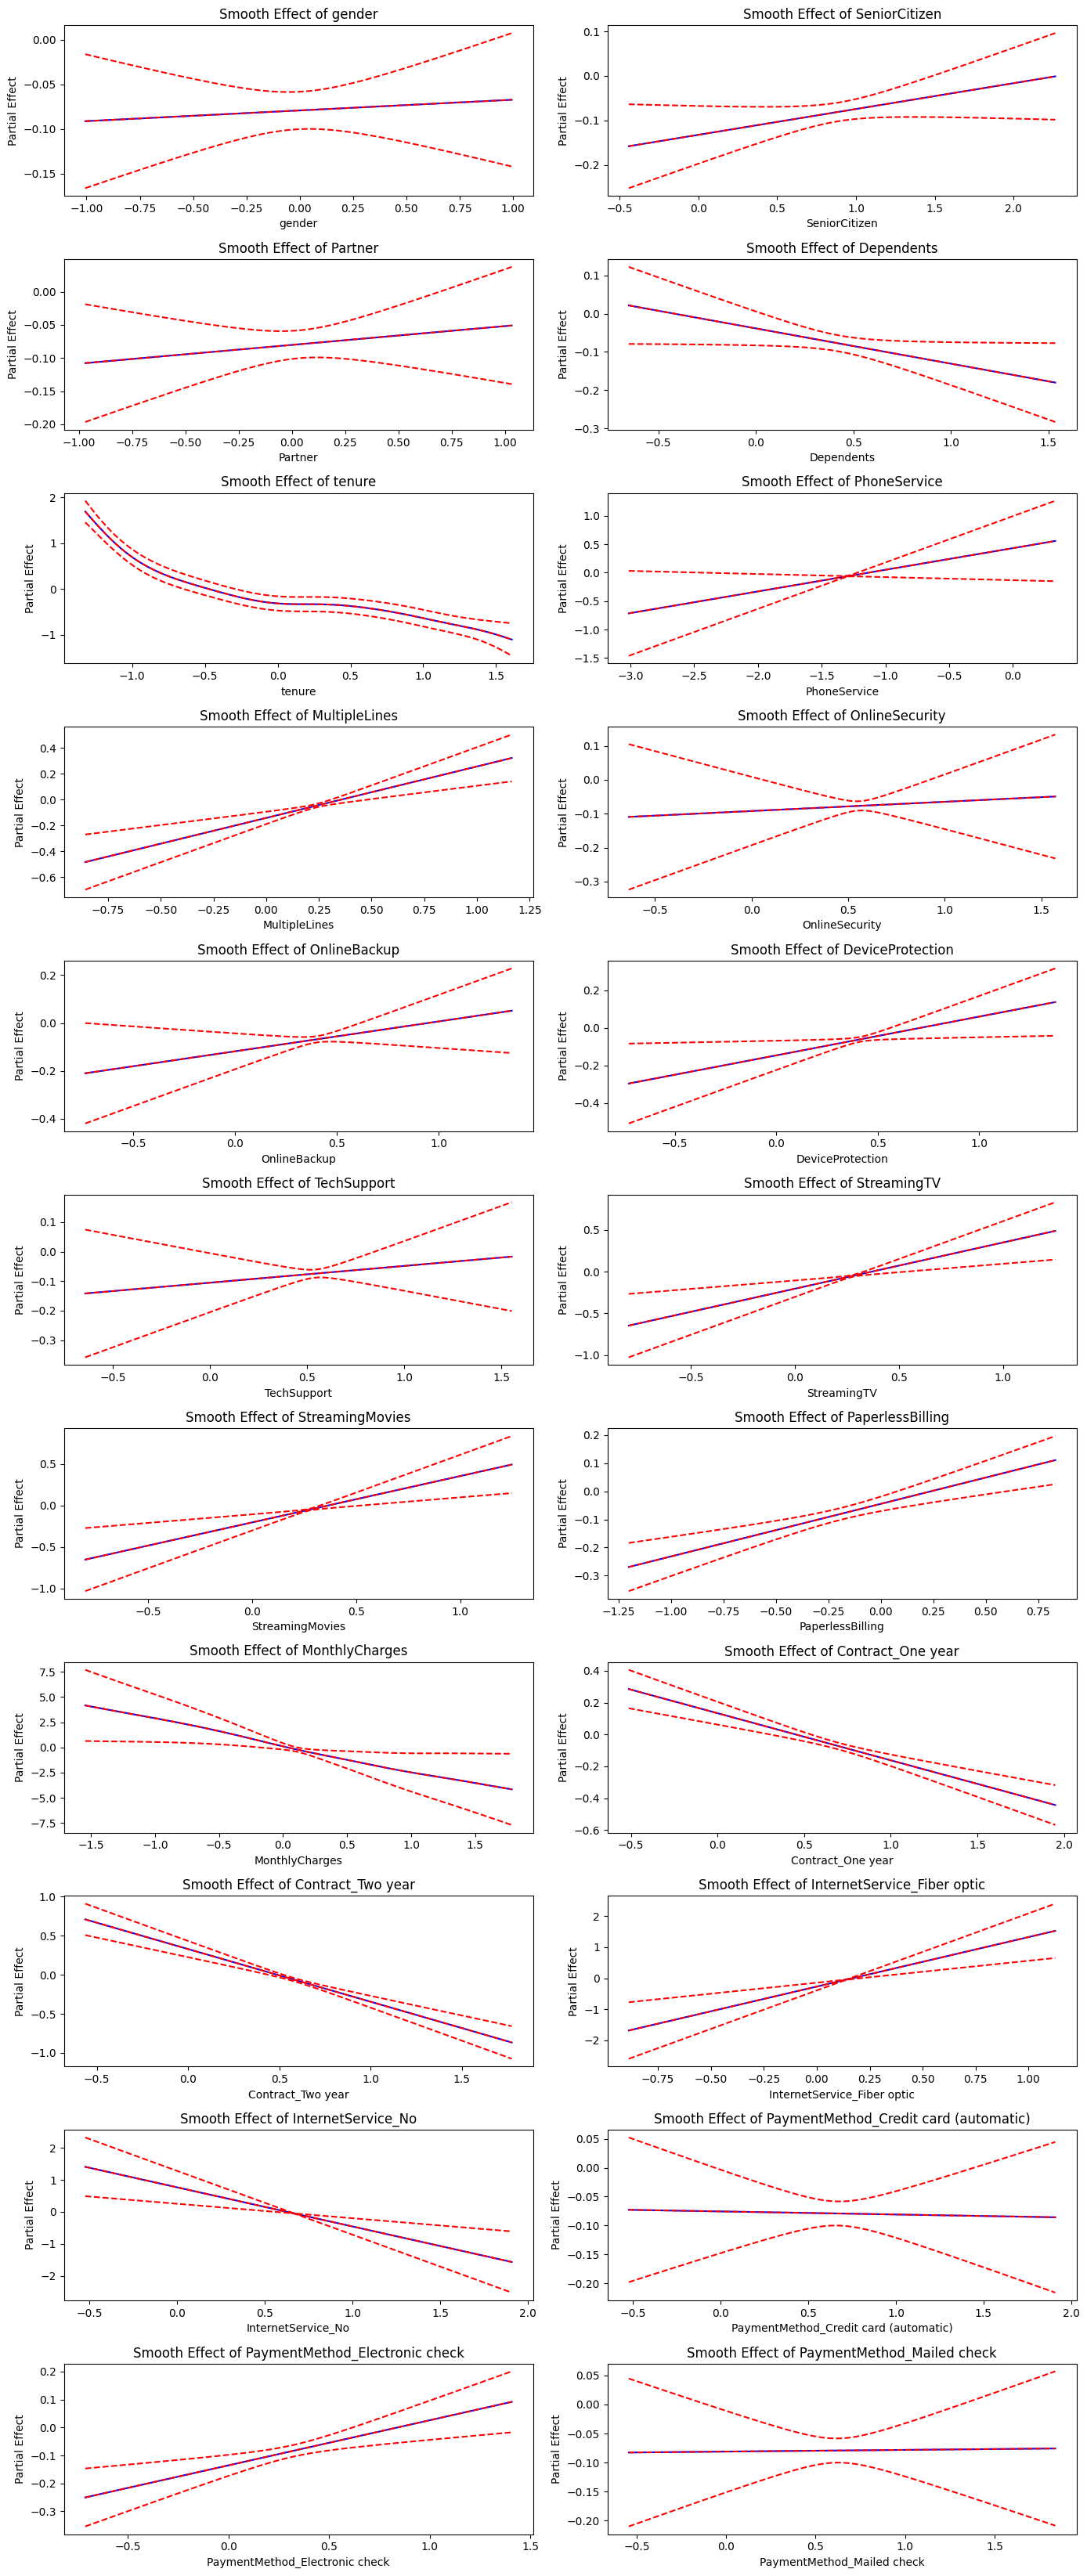

In [36]:
fig, axs = plt.subplots(len(X.columns)//2, 2, figsize=(14, 3*len(X.columns)//2))
axs = axs.flatten()

for i, col in enumerate(X.columns):
    XX = gam.generate_X_grid(term=i)

    # get partial dependence and confidence intervals
    pdep = gam.partial_dependence(term=i, X=XX)
    confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    axs[i].plot(XX[:, i], pdep, color="blue")
    axs[i].plot(XX[:, i], confi[0], color="red", ls="--")   # lower CI
    axs[i].plot(XX[:, i], confi[1], color="red", ls="--")   # upper CI

    axs[i].set_title(f"Smooth Effect of {col}")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Partial Effect")

plt.tight_layout()
plt.show()

# The above code snippet was generated using ChatGPT5 on 09/14/25 at 7:19pm.


Tenure has a strong negative effect, confirming that long-term customers are less likely to churn. Monthly charges exhibit a nonlinear effect, with both very low and very high charges associated with higher churn risk.

### Feature Importance Heatmap

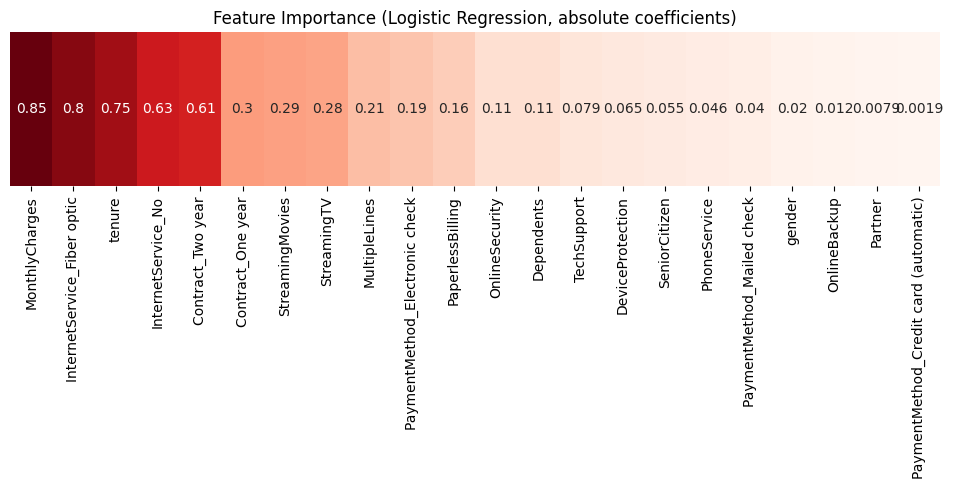

In [37]:
# Feature Importance Heatmap

coefs = pd.Series(log_model.coef_[0], index=X.columns)
importance = coefs.abs().sort_values(ascending=False)

plt.figure(figsize=(12, 2))
sns.heatmap(importance.to_frame().T, cmap="Reds", annot=True, cbar=False)
plt.title("Feature Importance (Logistic Regression, absolute coefficients)")
plt.yticks([])
plt.show()


Interpretation of Feature importance : Looks like MonthlyCharges, InternetService (Fiber optic) and tenure have high feature importance in terms of predicting churn.

# Final Comparision

Linear Regression: Simple but not accurate for binary outcomes, also linearity assumption was violated.

Logistic Regression: More accurate for classification problems but not capturing non-linear trends.

GAM: More flexible, captures nonlinearities, best predictive performance, but more complex to interpret.


# Results  

| Model                | Accuracy | AUC   | Notes |
|-----------------------|----------|-------|-------|
| Linear Regression     | ~0.79    | ~0.83 | Violates key assumptions, unstable for binary Y. |
| Logistic Regression   | ~0.74    | ~0.84 | Correct specification, stable, interpretable. |
| GAM                   | ~0.80    | ~0.85 | Best performance, captures nonlinearities. |

---


# Recommendations

Primary model: Logistic Regression should be the main model due to its interpretability and alignment with being easily interpretable.

Optional refinement: GAM can be used alongside logistic regression if the business wants to capture nonlinear effects and gain slightly better predictive performance, though at the cost of interpretability.

Not recommended: Linear Regression should not be used for churn prediction because it violates assumptions and produces unstable inference.